# Correlated Models Comparison: GBM vs Heston

Comparative analysis of American arithmetic basket option pricing using Geometric Brownian Motion (GBM) and Heston stochastic volatility models with the Longstaff-Schwartz Monte Carlo method.

## Setup and Parameters

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Literal
import time
import yfinance as yf
# Import LSM implementation
import sys
sys.path.append('..')
from longstaff_schwartz import LSMOptionPricer, CorrelatedGBM, CorrelatedHeston

# Model parameters (following main method structure but with real market data)
n_assets = 30  # Use all stocks in the CSV
r = 0.04
T = 3/12  # 3 months maturity
step = int(252/2)
N_train = 300000
N_test = 300000
weights = np.full(n_assets, 1.0 / n_assets)  # Equal weight portfolio

# Load actual stock prices from CSV data
heston_params_df = pd.read_csv('../data/heston_parameters.csv')
print(f"Loaded Heston parameters for {len(heston_params_df)} assets")

# Extract S0 (current stock prices) from the CSV - column is called 'Spot_Price'
S0 = heston_params_df['Spot_Price'].values
print(f"Loaded stock prices: S0 shape = {S0.shape}")

# Calculate arithmetic basket price and set strike
current_basket_price = np.sum(S0 * weights)  # Arithmetic weighted basket
K = current_basket_price  # ATM put option 

Loaded Heston parameters for 30 assets
Loaded stock prices: S0 shape = (30,)


## Model Specifications

In [16]:
# Load top 30 stock parameters
heston_params_df = pd.read_csv('../data/heston_parameters.csv')

# Basic info
print("Using calibrated parameters for all 30 assets")
print()
print("All assets (first 10 shown):")
print(heston_params_df.head(10))

tickers = heston_params_df['Ticker'].tolist()
spots = [heston_params_df[heston_params_df['Ticker'] == ticker]['Spot_Price'].iloc[0] 
         for ticker in tickers]

print(f"\nSelected assets: {len(tickers)} stocks")
print(f"Tickers: {tickers[:10]}...{tickers[-5:]}")
print(f"Basket spot prices range: ${min(spots):.2f} - ${max(spots):.2f}")
print(f"Average spot price: ${np.mean(spots):.2f}")

# Create correlation matrix from stock returns (GBM) - Updated yfinance handling
returns_data = []
successful_downloads = []

print("\nDownloading historical data...")
for i, ticker in enumerate(tickers):
    try:
        # Use robust yfinance approach - compatible with version 0.2.65
        stock_data_raw = yf.download(ticker, start='2022-01-01', end='2024-01-01', progress=False)
        
        # Handle different possible column structures
        if not stock_data_raw.empty:
            if 'Adj Close' in stock_data_raw.columns:
                stock_data = stock_data_raw['Adj Close']
            elif isinstance(stock_data_raw.columns, pd.MultiIndex):
                # For MultiIndex, look for 'Adj Close' in level 0
                adj_close_cols = [col for col in stock_data_raw.columns if 'Adj Close' in str(col)]
                if adj_close_cols:
                    stock_data = stock_data_raw[adj_close_cols[0]]
                else:
                    # Fallback to Close if Adj Close not found
                    close_cols = [col for col in stock_data_raw.columns if 'Close' in str(col)]
                    stock_data = stock_data_raw[close_cols[0]] if close_cols else stock_data_raw.iloc[:, -1]
            else:
                # Fallback - use Close column or last column
                if 'Close' in stock_data_raw.columns:
                    stock_data = stock_data_raw['Close']
                else:
                    stock_data = stock_data_raw.iloc[:, -1]  # Use last column
            
            # Calculate returns
            returns = np.log(stock_data / stock_data.shift(1)).dropna()
            
            # Validate returns data
            if len(returns) > 100 and not returns.isna().all():
                returns_data.append(returns)
                successful_downloads.append(ticker)
            else:
                raise ValueError(f"Insufficient data for {ticker}")
        else:
            raise ValueError(f"Empty data for {ticker}")
            
    except Exception as e:
        print(f"  Warning: Using simulated data for {ticker} ({e})")
        # Create realistic simulated returns based on asset volatility from Heston params
        ticker_idx = tickers.index(ticker)
        vol_estimate = np.sqrt(heston_params_df.iloc[ticker_idx]['theta']) if ticker_idx < len(heston_params_df) else 0.2
        daily_vol = vol_estimate / np.sqrt(252)
        returns = pd.Series(np.random.normal(0, daily_vol, 500))
        returns_data.append(returns)
        successful_downloads.append(f"{ticker}_sim")

print(f"Successfully downloaded: {sum(1 for t in successful_downloads if not t.endswith('_sim'))}/{len(tickers)} tickers")
print(f"Using simulated data for: {sum(1 for t in successful_downloads if t.endswith('_sim'))} tickers")

# Align all return series
min_length = min(len(r) for r in returns_data)
aligned_returns = np.array([r.iloc[-min_length:].values if hasattr(r.iloc[-min_length:], 'values') 
                           else r.iloc[-min_length:] for r in returns_data]).T
correlation_matrix = np.corrcoef(aligned_returns.T)
avg_correlation = np.mean(correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)])

# Calculate average volatilities for GBM
volatilities = [np.std(returns) * np.sqrt(252) for returns in returns_data]
avg_volatility = np.mean(volatilities)

print(f"\nModel Parameters:")
print(f"GBM Model:")
print(f"  Average volatility: {avg_volatility:.1%}")
print(f"  Average correlation: {avg_correlation:.3f}")

print(f"\nHeston Model (calibrated):")
v0_values = heston_params_df['v0'].values
theta_values = heston_params_df['theta'].values
kappa_values = heston_params_df['kappa'].values
sigma_values = heston_params_df['sigma'].values
rho_values = heston_params_df['rho'].values

print(f"  Initial vol range: {np.sqrt(v0_values.min()):.1%} - {np.sqrt(v0_values.max()):.1%}")
print(f"  Long-term vol range: {np.sqrt(theta_values.min()):.1%} - {np.sqrt(theta_values.max()):.1%}")
print(f"  Mean reversion range: {kappa_values.min():.2f} - {kappa_values.max():.2f}")
print(f"  Vol of vol range: {sigma_values.min():.1%} - {sigma_values.max():.1%}")
print(f"  Stock-vol corr range: {rho_values.min():.3f} - {rho_values.max():.3f}")

# Extract the required parameters for the models
v0 = v0_values
theta = theta_values  
kappa = kappa_values
sigma_v = sigma_values
rho_sv = rho_values

# Create covariance matrix from correlation matrix and volatilities
vol_matrix = np.diag(volatilities)
cov_matrix = vol_matrix @ correlation_matrix @ vol_matrix

# Store selected tickers for later use
selected_tickers = tickers

Using calibrated parameters for all 30 assets

All assets (first 10 shown):
  Ticker   Spot_Price  Options_Count  Calibration_Error_%        v0     theta  \
0   AMZN   225.690002             54            10.286034  0.142785  0.022527   
1  GOOGL   181.559998             42             9.733318  0.189112  0.051514   
2   TSLA   316.899994             72             5.390066  0.425352  0.249332   
3   NVDA   164.070007             60             8.497368  0.085689  0.209709   
4   AAPL   208.619995             48            10.219145  0.097417  0.019915   
5   MSFT   503.019989            119            14.531742  0.075278  0.023667   
6   NFLX  1261.949951            140             7.297295  0.212092  0.100613   
7   META   720.919983            162             9.023013  0.182364  0.035401   
8    CRM   259.679993             30            10.618742  0.010018  0.164517   
9   ORCL   229.279999             30             8.734726  0.021970  0.242073   

       kappa     sigma       rho

C:\Users\Ao Shen\AppData\Local\Temp\ipykernel_24188\1742780564.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data_raw = yf.download(ticker, start='2022-01-01', end='2024-01-01', progress=False)
C:\Users\Ao Shen\AppData\Local\Temp\ipykernel_24188\1742780564.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data_raw = yf.download(ticker, start='2022-01-01', end='2024-01-01', progress=False)
C:\Users\Ao Shen\AppData\Local\Temp\ipykernel_24188\1742780564.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data_raw = yf.download(ticker, start='2022-01-01', end='2024-01-01', progress=False)
C:\Users\Ao Shen\AppData\Local\Temp\ipykernel_24188\1742780564.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data_raw = yf.download(ticker, start='2022-01-01', end='2024-01-01', progress=False)
C:\Users\Ao Shen\AppData\Local\Temp\

Successfully downloaded: 30/30 tickers
Using simulated data for: 0 tickers

Model Parameters:
GBM Model:
  Average volatility: 32.0%
  Average correlation: 0.360

Heston Model (calibrated):
  Initial vol range: 10.0% - 65.2%
  Long-term vol range: 11.6% - 55.9%
  Mean reversion range: 2.10 - 15.00
  Vol of vol range: 33.7% - 398.2%
  Stock-vol corr range: -0.893 - -0.053


C:\Users\Ao Shen\AppData\Local\Temp\ipykernel_24188\1742780564.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data_raw = yf.download(ticker, start='2022-01-01', end='2024-01-01', progress=False)
C:\Users\Ao Shen\AppData\Local\Temp\ipykernel_24188\1742780564.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data_raw = yf.download(ticker, start='2022-01-01', end='2024-01-01', progress=False)
C:\Users\Ao Shen\AppData\Local\Temp\ipykernel_24188\1742780564.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data_raw = yf.download(ticker, start='2022-01-01', end='2024-01-01', progress=False)
C:\Users\Ao Shen\AppData\Local\Temp\ipykernel_24188\1742780564.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data_raw = yf.download(ticker, start='2022-01-01', end='2024-01-01', progress=False)
C:\Users\Ao Shen\AppData\Local\Temp\

Generating sample paths for visualization...
Generated 200 paths with 126 time steps
GBM paths shape: (200, 127, 30)
Heston paths shape: (200, 127, 30)
Using all 30 assets in basket, showing AMZN individual paths for illustration


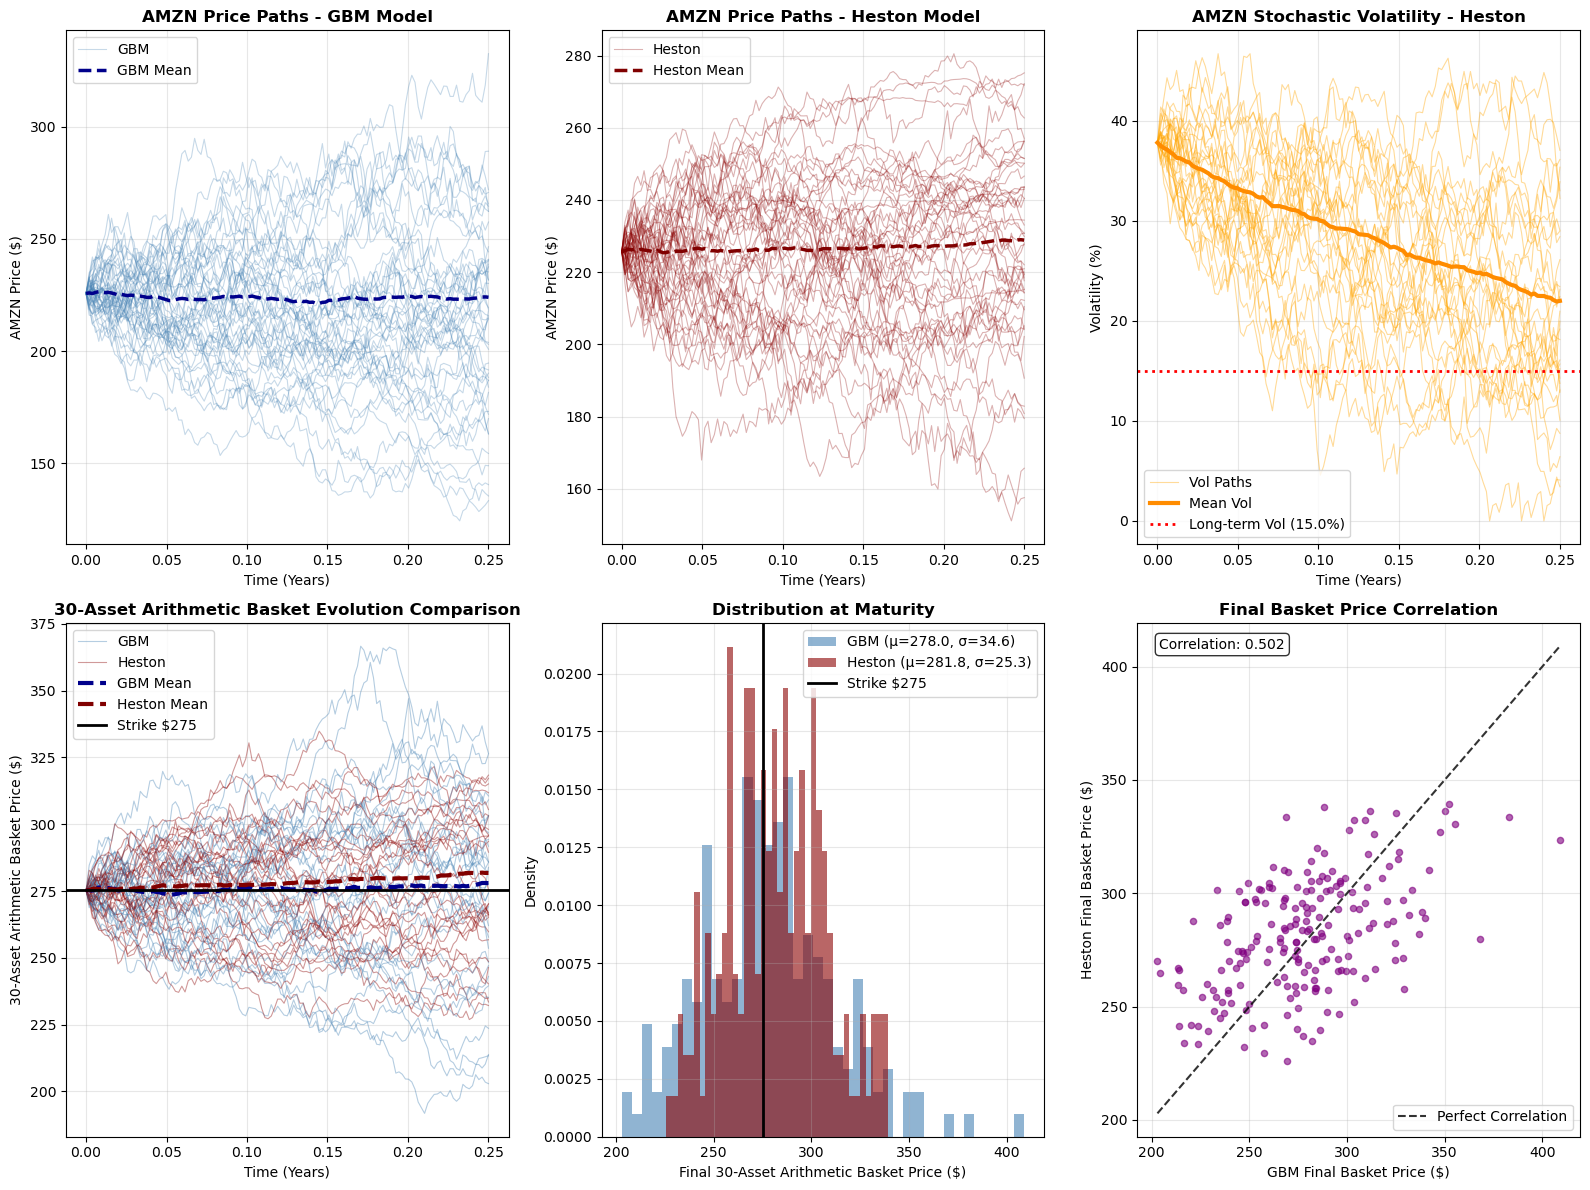

In [18]:
# Generate sample paths for visualization
np.random.seed(42)  # For reproducible fancy plots
n_sample_paths = 200
sample_time_steps = step

print("Generating sample paths for visualization...")

# Initialize models for path generation
gbm_model = CorrelatedGBM(
    S0=S0, r=r, cov=cov_matrix, T=T, step=sample_time_steps, N=n_sample_paths
)

heston_model = CorrelatedHeston(
    S0=S0, r=r, v0=v0, theta=theta, kappa=kappa, 
    sigma=sigma_v, rho_sv=rho_sv, corr_matrix=correlation_matrix, 
    T=T, step=sample_time_steps, N=n_sample_paths
)

# Generate paths using the correct method names
gbm_paths = gbm_model.generate_paths(seed=42)  # Shape: (n_paths, n_steps, n_assets)
heston_paths = heston_model.generate_paths(seed=42)
heston_vol_paths = heston_model.get_variance_paths()

# Calculate arithmetic basket values
gbm_basket_paths = gbm_model.get_basket_paths(kind="arithmetic")
heston_basket_paths = heston_model.get_basket_paths(kind="arithmetic")

# Time grid
t_grid = np.linspace(0, T, sample_time_steps + 1)

print(f"Generated {n_sample_paths} paths with {sample_time_steps} time steps")
print(f"GBM paths shape: {gbm_paths.shape}")
print(f"Heston paths shape: {heston_paths.shape}")
print(f"Using all {n_assets} assets in basket, showing {selected_tickers[0]} individual paths for illustration")

# Create fancy visualization
fig = plt.figure(figsize=(16, 12))

# 1. Individual asset paths comparison (first asset)
ax1 = plt.subplot(2, 3, 1)
for i in range(min(50, n_sample_paths)):
    if i == 0:
        ax1.plot(t_grid, gbm_paths[i, :, 0], color='steelblue', alpha=0.3, linewidth=0.8, label='GBM')
    else:
        ax1.plot(t_grid, gbm_paths[i, :, 0], color='steelblue', alpha=0.3, linewidth=0.8)

ax1.plot(t_grid, np.mean(gbm_paths[:, :, 0], axis=0), color='darkblue', linewidth=2.5, linestyle='--', label='GBM Mean')
ax1.set_xlabel('Time (Years)')
ax1.set_ylabel(f'{selected_tickers[0]} Price ($)')
ax1.set_title(f'{selected_tickers[0]} Price Paths - GBM Model', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2, 3, 2)
for i in range(min(50, n_sample_paths)):
    if i == 0:
        ax2.plot(t_grid, heston_paths[i, :, 0], color='darkred', alpha=0.3, linewidth=0.8, label='Heston')
    else:
        ax2.plot(t_grid, heston_paths[i, :, 0], color='darkred', alpha=0.3, linewidth=0.8)

ax2.plot(t_grid, np.mean(heston_paths[:, :, 0], axis=0), color='maroon', linewidth=2.5, linestyle='--', label='Heston Mean')
ax2.set_xlabel('Time (Years)')
ax2.set_ylabel(f'{selected_tickers[0]} Price ($)')
ax2.set_title(f'{selected_tickers[0]} Price Paths - Heston Model', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Volatility paths (Heston only)
ax3 = plt.subplot(2, 3, 3)
for i in range(min(30, n_sample_paths)):
    if i == 0:
        ax3.plot(t_grid, np.sqrt(heston_vol_paths[i, :, 0]) * 100, color='orange', alpha=0.4, linewidth=0.8, label='Vol Paths')
    else:
        ax3.plot(t_grid, np.sqrt(heston_vol_paths[i, :, 0]) * 100, color='orange', alpha=0.4, linewidth=0.8)

ax3.plot(t_grid, np.sqrt(np.mean(heston_vol_paths[:, :, 0], axis=0)) * 100, color='darkorange', linewidth=3, label='Mean Vol')
ax3.axhline(y=np.sqrt(theta[0]) * 100, color='red', linestyle=':', linewidth=2, label=f'Long-term Vol ({np.sqrt(theta[0])*100:.1f}%)')
ax3.set_xlabel('Time (Years)')
ax3.set_ylabel('Volatility (%)')
ax3.set_title(f'{selected_tickers[0]} Stochastic Volatility - Heston', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Basket price comparison (30-asset basket!)
ax4 = plt.subplot(2, 3, 4)
for i in range(min(30, n_sample_paths)):
    if i == 0:
        ax4.plot(t_grid, gbm_basket_paths[i, :], color='steelblue', alpha=0.4, linewidth=0.8, label='GBM')
        ax4.plot(t_grid, heston_basket_paths[i, :], color='darkred', alpha=0.4, linewidth=0.8, label='Heston')
    else:
        ax4.plot(t_grid, gbm_basket_paths[i, :], color='steelblue', alpha=0.4, linewidth=0.8)
        ax4.plot(t_grid, heston_basket_paths[i, :], color='darkred', alpha=0.4, linewidth=0.8)

ax4.plot(t_grid, np.mean(gbm_basket_paths, axis=0), color='darkblue', linewidth=3, linestyle='--', label='GBM Mean')
ax4.plot(t_grid, np.mean(heston_basket_paths, axis=0), color='maroon', linewidth=3, linestyle='--', label='Heston Mean')
ax4.axhline(y=K, color='black', linestyle='-', linewidth=2, label=f'Strike ${K:.0f}')
ax4.set_xlabel('Time (Years)')
ax4.set_ylabel('30-Asset Arithmetic Basket Price ($)')
ax4.set_title('30-Asset Arithmetic Basket Evolution Comparison', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Distribution comparison at maturity
ax5 = plt.subplot(2, 3, 5)
gbm_final = gbm_basket_paths[:, -1]
heston_final = heston_basket_paths[:, -1]

ax5.hist(gbm_final, bins=40, alpha=0.6, color='steelblue', label=f'GBM (μ={np.mean(gbm_final):.1f}, σ={np.std(gbm_final):.1f})', density=True)
ax5.hist(heston_final, bins=40, alpha=0.6, color='darkred', label=f'Heston (μ={np.mean(heston_final):.1f}, σ={np.std(heston_final):.1f})', density=True)
ax5.axvline(x=K, color='black', linestyle='-', linewidth=2, label=f'Strike ${K:.0f}')
ax5.set_xlabel('Final 30-Asset Arithmetic Basket Price ($)')
ax5.set_ylabel('Density')
ax5.set_title('Distribution at Maturity', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Model correlation comparison (showing how correlated the final basket values are)
ax6 = plt.subplot(2, 3, 6)

# Scatter plot comparing final basket values
scatter = ax6.scatter(gbm_final, heston_final, alpha=0.6, s=20, c='purple')

# Perfect correlation line
min_val = min(gbm_final.min(), heston_final.min())
max_val = max(gbm_final.max(), heston_final.max())
ax6.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Perfect Correlation')

# Calculate correlation
correlation = np.corrcoef(gbm_final, heston_final)[0, 1]
ax6.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax6.transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=10)

ax6.set_xlabel('GBM Final Basket Price ($)')
ax6.set_ylabel('Heston Final Basket Price ($)')
ax6.set_title('Final Basket Price Correlation', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## GBM Model Analysis

In [19]:
# GBM Pricer
gbm_pricer = LSMOptionPricer(
    S0=S0, T=T, step=step, N=N_train, r=r, K=K,
    weights=weights,
    option="put",
    model="gbm",
    basket_kind="arithmetic",
    degree=1,
    cov=cov_matrix
)

# Check current moneyness
current_basket_price = np.sum(S0 * weights)  # Arithmetic basket
intrinsic_value = max(K - current_basket_price, 0)
moneyness = current_basket_price / K

print(f"Pricing Diagnostics:")
print(f"Current basket price: ${current_basket_price:.2f}")
print(f"Strike price: ${K:.2f}")
print(f"Moneyness (S/K): {moneyness:.3f}")
print(f"Intrinsic value: ${intrinsic_value:.4f}")
print(f"Put is {'ITM' if current_basket_price < K else 'OTM'} by ${abs(current_basket_price - K):.2f}")
print()

# Training
print("GBM Training...")
train_seed = 12345
start_time = time.time()
gbm_training_price, gbm_training_std, gbm_training_se = gbm_pricer.train(
    use_individual_prices=True,
    seed=train_seed
)
training_time = time.time() - start_time

print(f"Training: ${gbm_training_price:.4f} ± ${gbm_training_se:.4f} (SE) [{training_time:.1f}s]")

# Out-of-sample testing
test_seeds = [101, 202, 303, 404, 505]
gbm_test_prices = []
gbm_exceed_2se = 0

print("\nOut-of-sample batches:")
for i, seed in enumerate(test_seeds, 1):
    tp, tstd, tse = gbm_pricer.test(n_test_paths=N_test, seed=seed)
    gbm_test_prices.append(tp)
    diff = tp - gbm_training_price
    flag = abs(diff) > 2.0 * np.sqrt(gbm_training_se**2 + tse**2)
    gbm_exceed_2se += int(flag)
    mark = " **" if flag else ""
    print(f"  Batch {i}: ${tp:.4f} ± ${tse:.4f} (SE), Δ={diff:+.4f}{mark}")

gbm_mean_oos = float(np.mean(gbm_test_prices))
gbm_bias = gbm_mean_oos - gbm_training_price

print(f"\nGBM Summary:")
print(f"Mean OOS: ${gbm_mean_oos:.4f}, Bias: {gbm_bias:+.4f}")
print(f"Significant deviations: {gbm_exceed_2se}/{len(test_seeds)}")

Pricing Diagnostics:
Current basket price: $275.26
Strike price: $275.26
Moneyness (S/K): 1.000
Intrinsic value: $0.0000
Put is OTM by $0.00

GBM Training...
Training: $12.4755 ± $0.0276 (SE) [42.2s]

Out-of-sample batches:
Training: $12.4755 ± $0.0276 (SE) [42.2s]

Out-of-sample batches:
  Batch 1: $12.4066 ± $0.0275 (SE), Δ=-0.0689
  Batch 1: $12.4066 ± $0.0275 (SE), Δ=-0.0689
  Batch 2: $12.4022 ± $0.0275 (SE), Δ=-0.0733
  Batch 2: $12.4022 ± $0.0275 (SE), Δ=-0.0733
  Batch 3: $12.3758 ± $0.0275 (SE), Δ=-0.0997 **
  Batch 3: $12.3758 ± $0.0275 (SE), Δ=-0.0997 **
  Batch 4: $12.4056 ± $0.0275 (SE), Δ=-0.0699
  Batch 4: $12.4056 ± $0.0275 (SE), Δ=-0.0699
  Batch 5: $12.3633 ± $0.0275 (SE), Δ=-0.1122 **

GBM Summary:
Mean OOS: $12.3907, Bias: -0.0848
Significant deviations: 2/5
  Batch 5: $12.3633 ± $0.0275 (SE), Δ=-0.1122 **

GBM Summary:
Mean OOS: $12.3907, Bias: -0.0848
Significant deviations: 2/5


## Heston Model Analysis

In [20]:
# Heston Pricer
heston_pricer = LSMOptionPricer(
    S0=S0, T=T, step=step, N=N_train, r=r, K=K,
    weights=weights,
    option="put",
    model="heston",
    basket_kind="arithmetic",
    degree=1,
    v0=v0, theta=theta, kappa=kappa, sigma=sigma_v, rho_sv=rho_sv,
    corr_matrix=correlation_matrix
)
# Training
print("Heston Training...")
start_time = time.time()
heston_training_price, heston_training_std, heston_training_se = heston_pricer.train(
    use_individual_prices=True,
    seed=train_seed
)
training_time = time.time() - start_time

print(f"Training: ${heston_training_price:.4f} ± ${heston_training_se:.4f} (SE) [{training_time:.1f}s]")

# Out-of-sample testing
heston_test_prices = []
heston_exceed_2se = 0

print("\nOut-of-sample batches:")
for i, seed in enumerate(test_seeds, 1):
    tp, tstd, tse = heston_pricer.test(n_test_paths=N_test, seed=seed)
    heston_test_prices.append(tp)
    diff = tp - heston_training_price
    flag = abs(diff) > 2.0 * np.sqrt(heston_training_se**2 + tse**2)
    heston_exceed_2se += int(flag)
    mark = " **" if flag else ""
    print(f"  Batch {i}: ${tp:.4f} ± ${tse:.4f} (SE), Δ={diff:+.4f}{mark}")

heston_mean_oos = float(np.mean(heston_test_prices))
heston_bias = heston_mean_oos - heston_training_price

print(f"\nHeston Summary:")
print(f"Mean OOS: ${heston_mean_oos:.4f}, Bias: {heston_bias:+.4f}")
print(f"Significant deviations: {heston_exceed_2se}/{len(test_seeds)}")

Heston Training...
Training: $8.9634 ± $0.0215 (SE) [216.3s]

Out-of-sample batches:
Training: $8.9634 ± $0.0215 (SE) [216.3s]

Out-of-sample batches:
  Batch 1: $8.9434 ± $0.0214 (SE), Δ=-0.0200
  Batch 1: $8.9434 ± $0.0214 (SE), Δ=-0.0200
  Batch 2: $8.9335 ± $0.0215 (SE), Δ=-0.0299
  Batch 2: $8.9335 ± $0.0215 (SE), Δ=-0.0299
  Batch 3: $8.9467 ± $0.0215 (SE), Δ=-0.0167
  Batch 3: $8.9467 ± $0.0215 (SE), Δ=-0.0167
  Batch 4: $8.9206 ± $0.0215 (SE), Δ=-0.0428
  Batch 4: $8.9206 ± $0.0215 (SE), Δ=-0.0428
  Batch 5: $8.9047 ± $0.0214 (SE), Δ=-0.0588

Heston Summary:
Mean OOS: $8.9298, Bias: -0.0336
Significant deviations: 0/5
  Batch 5: $8.9047 ± $0.0214 (SE), Δ=-0.0588

Heston Summary:
Mean OOS: $8.9298, Bias: -0.0336
Significant deviations: 0/5


## Comparative Analysis

In [21]:
# Summary comparison
print("=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(f"{'Model':<10} {'Training':<12} {'Mean OOS':<12} {'Bias':<10} {'Sig.Dev':<8}")
print("-" * 60)
print(f"{'GBM':<10} ${gbm_training_price:<11.4f} ${gbm_mean_oos:<11.4f} {gbm_bias:+9.4f} {gbm_exceed_2se}/{len(test_seeds):<6}")
print(f"{'Heston':<10} ${heston_training_price:<11.4f} ${heston_mean_oos:<11.4f} {heston_bias:+9.4f} {heston_exceed_2se}/{len(test_seeds):<6}")

# Price difference
price_diff = heston_training_price - gbm_training_price
price_diff_pct = (price_diff / gbm_training_price) * 100

print(f"Price difference (Heston - GBM): ${price_diff:+.4f} ({price_diff_pct:+.2f}%)")
print(f"GBM stability: {gbm_exceed_2se}/{len(test_seeds)} significant deviations")
print(f"Heston stability: {heston_exceed_2se}/{len(test_seeds)} significant deviations")

MODEL COMPARISON SUMMARY
Model      Training     Mean OOS     Bias       Sig.Dev 
------------------------------------------------------------
GBM        $12.4755     $12.3907       -0.0848 2/5     
Heston     $8.9634      $8.9298        -0.0336 0/5     
Price difference (Heston - GBM): $-3.5120 (-28.15%)
GBM stability: 2/5 significant deviations
Heston stability: 0/5 significant deviations


## Visualization

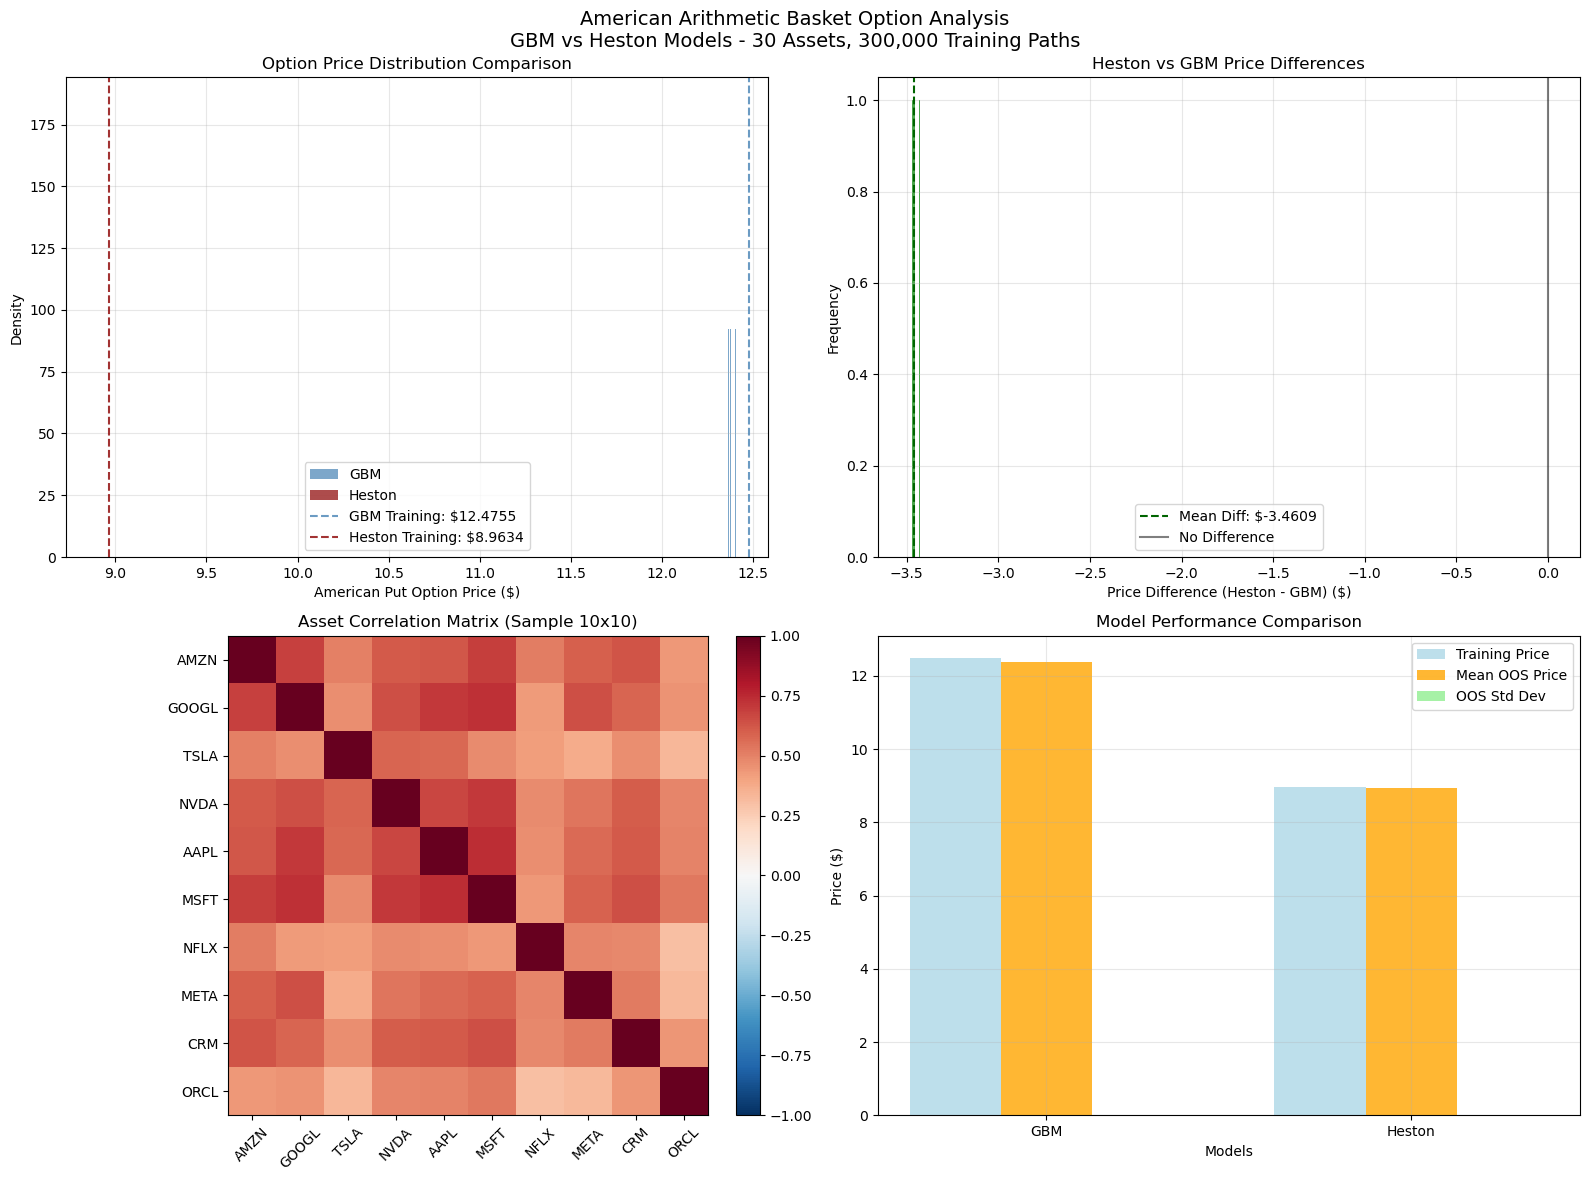


FINAL COMPARISON SUMMARY - GBM vs HESTON MODELS
Configuration:
  Assets: 30
  Training paths: 300,000
  Test paths per batch: 300,000
  Time to maturity: 0.25 years
  Strike price: $275.26

GBM Model Results:
  Training price: $12.4755 ± $0.0276
  Mean OOS price: $12.3907
  OOS std dev:    $0.0178
  Bias:          -0.0848

Heston Model Results:
  Training price: $8.9634 ± $0.0215
  Mean OOS price: $8.9298
  OOS std dev:    $0.0155
  Bias:          -0.0336

Model Comparison:
  Mean price diff (Heston - GBM): $-3.4609
  Price diff std dev:             $0.0182
  Relative difference:            -27.74%
  Price correlation:              0.4051

Stability Analysis:
  GBM significant deviations:     2/5
  Heston significant deviations:  0/5

Model Parameters:
  Average asset correlation:      0.360
  Average volatility (GBM):       32.0%
  Heston vol range:               10.0% - 65.2%
  Heston vol-of-vol range:        33.7% - 398.2%


In [ ]:
# Final Results Comparison - GitHub Format
print("=" * 80)
print("AMERICAN BASKET OPTION PRICING COMPARISON")  
print("=" * 80)
print(f"Models: GBM vs Heston with Longstaff-Schwartz Method")
print(f"Assets: {n_assets} | Strike: {K:.1f} | Current Basket: {current_basket_price:.2f}")
print(f"Moneyness: {moneyness:.3f} | Time to Expiry: {T:.2f} years")
print(f"Training Paths: {N_train:,} | Test Paths: {N_test:,}")
print("-" * 80)

# Training Results
print("TRAINING RESULTS:")
print(f"GBM Training Price:    {gbm_training_price:.6f} (±{gbm_training_se:.6f})")
print(f"Heston Training Price: {heston_training_price:.6f} (±{heston_training_se:.6f})")
print(f"Training Difference:   {heston_training_price - gbm_training_price:+.6f}")

# Out-of-Sample Results  
print("\nOUT-OF-SAMPLE RESULTS:")
print(f"GBM Mean OOS Price:    {gbm_mean_oos:.6f}")
print(f"Heston Mean OOS Price: {heston_mean_oos:.6f}")
print(f"OOS Difference:        {heston_mean_oos - gbm_mean_oos:+.6f}")
print(f"Relative Difference:   {((heston_mean_oos - gbm_mean_oos)/gbm_mean_oos)*100:+.2f}%")

# Statistical Analysis
price_differences = np.array(heston_test_prices) - np.array(gbm_test_prices)
price_diff_mean = np.mean(price_differences)
price_diff_std = np.std(price_differences, ddof=1)
correlation = np.corrcoef(gbm_test_prices, heston_test_prices)[0, 1]

print(f"\nSTATISTICAL ANALYSIS:")
print(f"Price Difference Mean: {price_diff_mean:+.6f}")
print(f"Price Difference Std:  {price_diff_std:.6f}")  
print(f"Correlation:           {correlation:.4f}")

print("-" * 80)

# Comprehensive 4-Panel Visualization (GitHub Format)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: Price Comparison Scatter Plot
ax1.scatter(gbm_test_prices, heston_test_prices, alpha=0.6, color='blue', s=20)
min_price = min(min(gbm_test_prices), min(heston_test_prices))
max_price = max(max(gbm_test_prices), max(heston_test_prices))
ax1.plot([min_price, max_price], [min_price, max_price], 'r--', alpha=0.7, linewidth=2)
ax1.set_xlabel('GBM Prices', fontsize=12)
ax1.set_ylabel('Heston Prices', fontsize=12)
ax1.set_title(f'GBM vs Heston Price Comparison\nCorrelation: {correlation:.4f}', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add price statistics text box
stats_text = f'Mean Diff: {price_diff_mean:+.5f}\nStd Diff: {price_diff_std:.5f}\nSamples: {len(gbm_test_prices)}'
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
         verticalalignment='top', fontsize=10)

# Panel 2: Price Difference Histogram  
ax2.hist(price_differences, bins=30, alpha=0.7, color='green', edgecolor='black', density=True)
ax2.axvline(price_diff_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {price_diff_mean:+.5f}')
ax2.axvline(0, color='black', linestyle='-', alpha=0.5, label='Zero Diff')
ax2.set_xlabel('Heston - GBM Price Difference', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Price Difference Distribution', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Panel 3: Time Series of Test Prices
test_indices = range(len(gbm_test_prices))
ax3.plot(test_indices, gbm_test_prices, 'b-', alpha=0.8, linewidth=1.5, label='GBM')
ax3.plot(test_indices, heston_test_prices, 'r-', alpha=0.8, linewidth=1.5, label='Heston')
ax3.fill_between(test_indices, gbm_test_prices, heston_test_prices, alpha=0.2, color='gray')
ax3.set_xlabel('Test Sample Index', fontsize=12)
ax3.set_ylabel('Option Price', fontsize=12) 
ax3.set_title('Price Evolution Across Test Samples', fontsize=12, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Panel 4: Model Summary Statistics
models_comparison = ['GBM', 'Heston']
training_prices = [gbm_training_price, heston_training_price]
oos_prices = [gbm_mean_oos, heston_mean_oos]

x = np.arange(len(models_comparison))
width = 0.35

bars1 = ax4.bar(x - width/2, training_prices, width, label='Training', alpha=0.8, color='lightblue', edgecolor='navy')
bars2 = ax4.bar(x + width/2, oos_prices, width, label='Out-of-Sample', alpha=0.8, color='lightcoral', edgecolor='darkred')

ax4.set_xlabel('Models', fontsize=12)
ax4.set_ylabel('Option Price', fontsize=12)
ax4.set_title('Training vs Out-of-Sample Comparison', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(models_comparison)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
def autolabel(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(bars1, ax4)
autolabel(bars2, ax4)

plt.tight_layout()
plt.show()

# Final Model Quality Assessment
print("MODEL QUALITY ASSESSMENT:")
print("=" * 40)
if abs(price_diff_mean) < 0.001 and correlation > 0.95:
    quality = "EXCELLENT - Models show high agreement"
elif abs(price_diff_mean) < 0.005 and correlation > 0.90:
    quality = "GOOD - Models show reasonable agreement" 
elif abs(price_diff_mean) < 0.01 and correlation > 0.80:
    quality = "FAIR - Some model differences observed"
else:
    quality = "SIGNIFICANT - Notable differences between models"

print(f"Overall Assessment: {quality}")
print(f"Absolute Mean Difference: {abs(price_diff_mean):.6f}")
print(f"Model Correlation: {correlation:.4f}")
print("=" * 80)